Import libraries

In [2]:
import os

import pandas as pd

import numpy as np

from sklearn import preprocessing

from scipy import stats
import scipy.stats as sc
from scipy.cluster.hierarchy import linkage,leaves_list

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from import_data import load_data

Import data

In [3]:
def elapsedtime_to_sec(el):
    tab = el.split(":")
    return float(tab[0])*60+float(tab[1])
#because x264 output is "m:s", where m is the number of minutes and s the number of seconds 

res_dir = "../../data/res_ugc/"

v_names = sorted(os.listdir(res_dir)) # so we keep the same ids between two launches

listVideo = []

for v in v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    listVideo.append(data)

In [4]:
listVideo[0]['size']

0      403085
1      234157
2      159836
3      163586
4      218392
        ...  
196    183183
197    195730
198    178146
199    234018
200    192116
Name: size, Length: 201, dtype: int64

We expect to predict the elapsed time

In [5]:
# the variable we expect to predict 
#predDimension = "cpu"
predDimension ="size"
#predDimension ="fps"
#predDimension ="kbs"

Correlation and divergence matrix

In [6]:
nbVideos = len(listVideo)
# Pearson correlation matrix
corrPearson= [[0 for x in range(nbVideos)] for y in range(nbVideos)]
# Kullback-Leibler divergence matrix
divKL = [[0 for x in range(nbVideos)] for y in range(nbVideos)]


for i in range(nbVideos):
    for j in range(nbVideos):
        if (i == j):
            corrPearson[i][j] = 1
            divKL[i][j] = 0
        else:
            corrPearson[i][j] = np.corrcoef(listVideo[i][predDimension],listVideo[j][predDimension])[0,1]
            divKL[i][j] = sc.entropy(pk=listVideo[i][predDimension], qk=listVideo[j][predDimension])

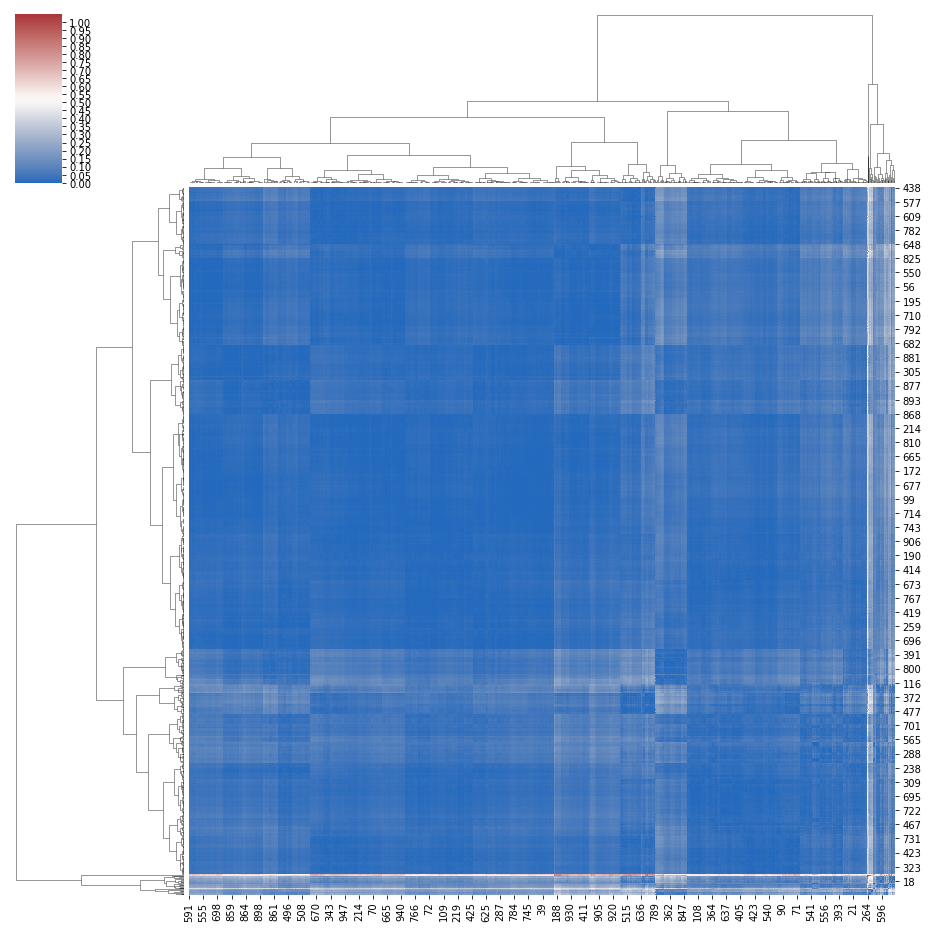

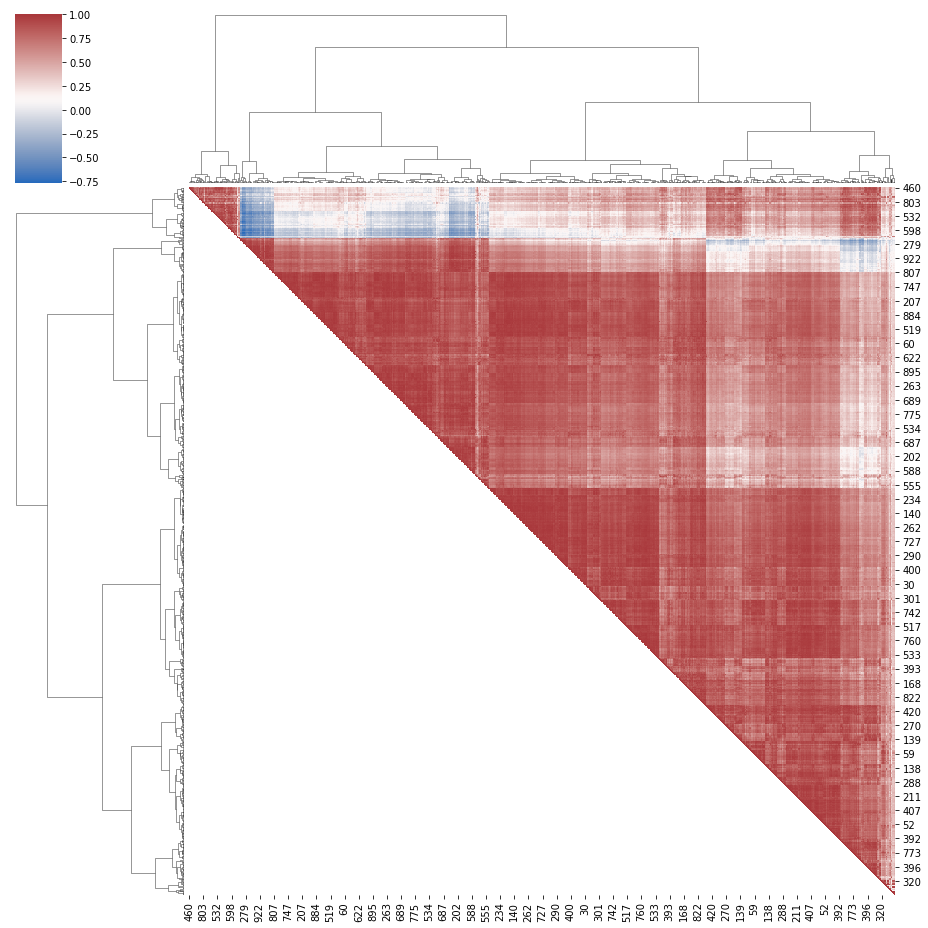

In [8]:
result_dir = "../../results/"

def plot_correlationmatrix_dendogram(corr, img_name, method, ticks, div=False):

    df = pd.DataFrame(corr)
    
    # group the videos
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)

    for i in range(nbVideos):
        for j in range(nbVideos):
            if i>j:
                mask[order[i]][order[j]] = True
    
    if div:
        # the KL divergence is not symetric
        # div(x,y) is slightly different from div(y,x)
        sns.clustermap(df, cmap="vlag", method=method,
                   linewidths=0, figsize=(13, 13), cbar_kws={"ticks":ticks})
    else:
        #the correlation is symetric so it's useless to print the bottom-left diagonal
        sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), cbar_kws={"ticks":ticks})
    
    plt.savefig(result_dir+img_name)
    plt.show()

method = 'ward'
plot_correlationmatrix_dendogram(divKL, 
                                 "corrmatrix-dendo-KL-" + predDimension + ".pdf", 
                                 method, 
                                 [k/20 for k in range(50)], div=True)
plot_correlationmatrix_dendogram(corrPearson, 
                                 "corrmatrix-dendo-Pearson-" + predDimension + ".pdf", 
                                 method, 
                                 [k/4 for k in np.arange(-10,10,1)])

Good and bad examples of linear correlation between videos

In [9]:
def plotCorrelationVideo(v1ID, v2ID,plot=True, filename=None):
    video1 = listVideo[v1ID][:]
    video2 = listVideo[v2ID][:]
    v1 = video1[predDimension]
    v2 = video2[predDimension]
    corr_pear_c = np.corrcoef(v1,v2)[0,1]
    
    if plot:
        fig = plt.figure()
        plt.scatter(v1,v2)   
        slope, intercept, r_value, p_value, std_err = stats.linregress(v1, v2)
        plt.plot(v1,slope*v1+intercept,color="black")   
        plt.xlabel("Video %d (%s)" % (v1ID, predDimension))
        plt.ylabel("Video %d (%s)" % (v2ID, predDimension))
        plt.title("Pearson correlation: " + str(round(corr_pear_c, 2)))
        if (filename is None): # default
            filename = "correlation-v" + str(v1ID) + "v" + str(v2ID) + ".pdf"
        fig.savefig(result_dir+filename, format="pdf", bbox_inches='tight')
    return corr_pear_c

if (predDimension == "elapsedtime"):
    # example (worst)
    v1ID = 4
    v2ID = 11
    # example (good)
    v1goodID = 12
    v2goodID = 0
    
    plotCorrelationVideo(v1ID, v2ID, plot=True)
    plotCorrelationVideo(v1goodID, v2goodID, plot=True)
    
if (predDimension == "fps"):
    # example (worst)
    v1ID = 4
    v2ID = 11
    # example (good)
    v1goodID = 12
    v2goodID = 0
    
    plotCorrelationVideo(v1ID, v2ID, plot=True)
    plotCorrelationVideo(v1goodID, v2goodID, plot=True)
    

Boxplot of video size distributions

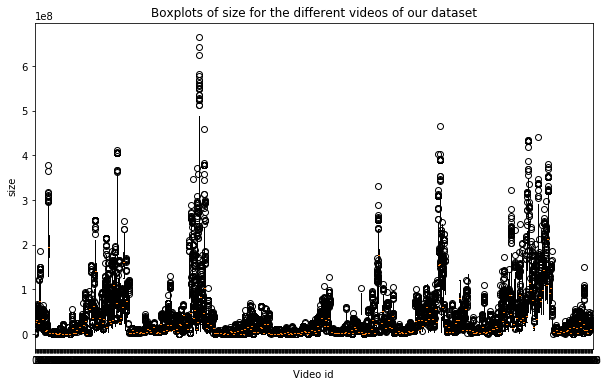

In [11]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

time = []

for i in range(nbVideos):
    time.append(listVideo[i][predDimension])

bp = ax.boxplot(time)
ax.set_xticklabels(range(nbVideos))

plt.title("Boxplots of "+str(predDimension)+" for the different videos of our dataset")
plt.ylabel(predDimension)
plt.xlabel("Video id")

plt.show()
